# Data Resampling: An Introduction

Often, the reason we need temperature data is to explore the relationship between weather and energy use for a particular building, home, or collection of homes. To quantify this relationship, we need both temperature and energy observations to be on the same time scale - whether that is hourly, half-hourly, etc. Unfortunately, however, readings from weather stations aren't always available at the particular time scale of your meter readings, and indeed, they aren't even necessarily at regular intervals at all (the NOAA Integrated Surface Dataset has some stations that sometimes emit data every two minutes and sometimes every twenty minutes, for example).

`riweather` has some tools to ease the process of aligning temperature data to a certain time scale. It builds on top of the [resampling functionality of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling). This tutorial illustrates the different options at your disposal, so that you can handle the alignment exactly how you need to.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import riweather

%matplotlib inline

## Resampling strategies on a toy example

Suppose we have the following ten weather observations. They occur twenty minutes apart, at 15, 35, and 55 minutes past the hour.

In [2]:
temps = pd.Series(
    [0, 9, 3, 1, 2, 5, 8, 6, 4, 7],
    index=pd.date_range("2023-01-01 00:15", periods=10, freq="20min"),
    name="tempC",
)

In [3]:
temps

2023-01-01 00:15:00    0
2023-01-01 00:35:00    9
2023-01-01 00:55:00    3
2023-01-01 01:15:00    1
2023-01-01 01:35:00    2
2023-01-01 01:55:00    5
2023-01-01 02:15:00    8
2023-01-01 02:35:00    6
2023-01-01 02:55:00    4
2023-01-01 03:15:00    7
Freq: 20min, Name: tempC, dtype: int64

In [4]:
def plot_temps(datasets, labels, raw_idx=0):
    import matplotlib.dates as mdates

    fig, ax = plt.subplots(figsize=(12, 4))
    fig.suptitle("Temperature resampling")
    for i, (d, l) in enumerate(zip(datasets, labels, strict=True)):
        if i == raw_idx:
            ax.plot(d, "D", color="black", alpha=0.2, label=l)
        else:
            ax.plot(d, "x-", label=l)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
    ax.set_ylabel("Temperature (C)")
    _ = ax.legend()
    plt.show()

In [5]:
datasets = [temps]
labels = ["Actual observations"]

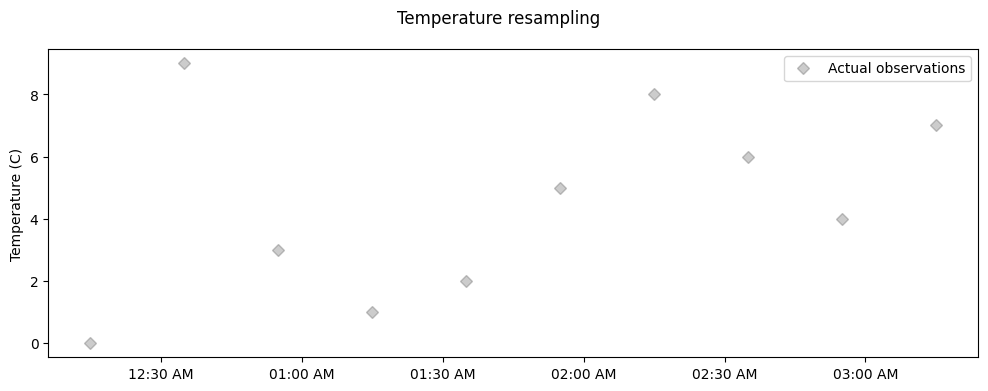

In [6]:
plot_temps(datasets, labels)

### The four `rollup_*()` functions

We need to align these temperatures to a dataset of smart meter readings that occur at the top of every hour. How can we do this?

One option is to take the average of all readings over the previous hour. So, for 1 AM, the previous hour's readings were 0, 9, and 3 degrees, and the average is 4. With `riweather` we can do this with `rollup_ending()`. The word "ending" in the name means that we are calculating "hour-ending" values.

Because meter readings are typically collected as hour-ending values as well, `rollup_ending()` is the default behavior of the all-in-one fetching method [`riweather.Station.fetch_data`][] when a resampling `period` is specified.

In [7]:
temps_ending = riweather.rollup_ending(temps, "h", upsample_first=False)
temps_ending

2023-01-01 01:00:00    4.000000
2023-01-01 02:00:00    2.666667
2023-01-01 03:00:00    6.000000
2023-01-01 04:00:00    7.000000
Freq: h, Name: tempC, dtype: float64

In [8]:
datasets.append(temps_ending)
labels.append("Hourly resampling, hour-ending")

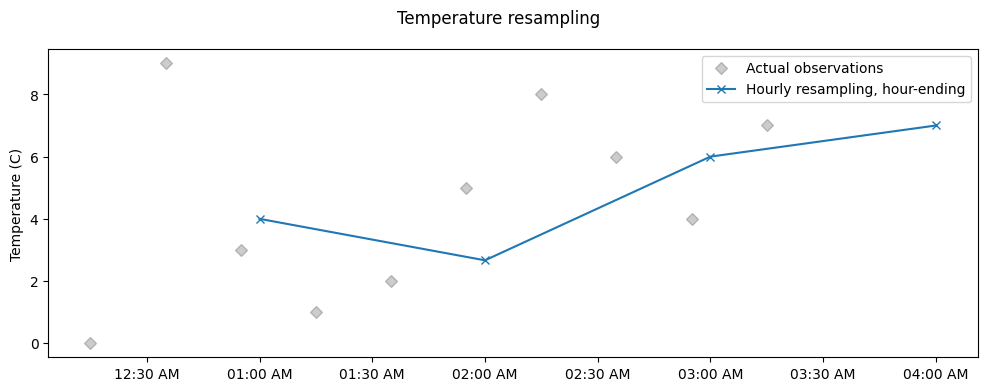

In [9]:
plot_temps(datasets, labels)

You can get hour-_starting_ values instead with `rollup_starting()`. Notice that the first three readings are still averaged together, but the timestamp assigned to the result is midnight (the start of the hour), instead of 1 AM.

In [10]:
temps_starting = riweather.rollup_starting(temps, "h", upsample_first=False)
temps_starting

2023-01-01 00:00:00    4.000000
2023-01-01 01:00:00    2.666667
2023-01-01 02:00:00    6.000000
2023-01-01 03:00:00    7.000000
Freq: h, Name: tempC, dtype: float64

In [11]:
datasets.append(temps_starting)
labels.append("Hourly resampling, hour-starting")

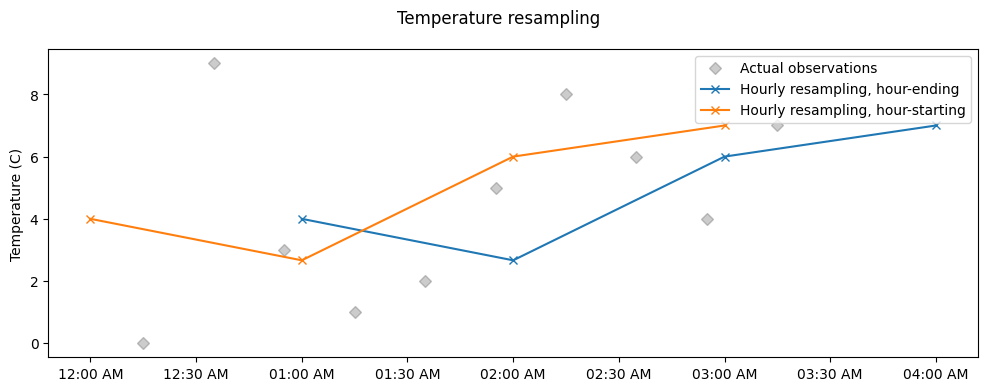

In [12]:
plot_temps(datasets, labels)

Instead of hour-ending or hour-starting values, you might want the range over which the average is taken to extend both forward and backward. Using `rollup_midpoint()`, the value at 1 AM will be the average over all data between 12:30 and 1:30 AM.

In [15]:
temps_midpoint = riweather.rollup_midpoint(temps, "h", upsample_first=False)
temps_midpoint

2023-01-01 00:00:00    0.000000
2023-01-01 01:00:00    4.333333
2023-01-01 02:00:00    5.000000
2023-01-01 03:00:00    5.666667
Freq: h, Name: tempC, dtype: float64

In [16]:
datasets.append(temps_midpoint)
labels.append("Hourly resampling, midpoint")

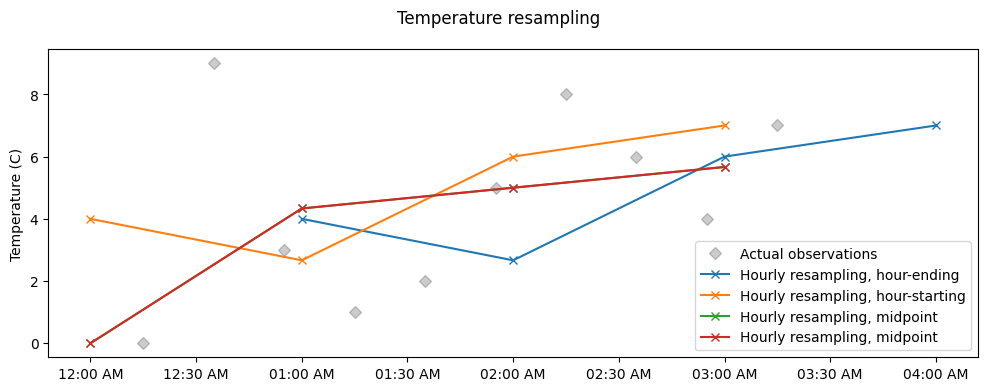

In [17]:
plot_temps(datasets, labels)

Finally, `rollup_instant()` does not do any averaging at all. Instead, the value for a certain hour will simply be the first actual data point during that hour.

In [18]:
temps_instant = riweather.rollup_instant(temps, "h", upsample_first=False)
temps_instant

2023-01-01 00:00:00    0
2023-01-01 01:00:00    1
2023-01-01 02:00:00    8
2023-01-01 03:00:00    7
Freq: h, Name: tempC, dtype: int64

In [19]:
datasets.append(temps_instant)
labels.append("Hourly resampling, instant")

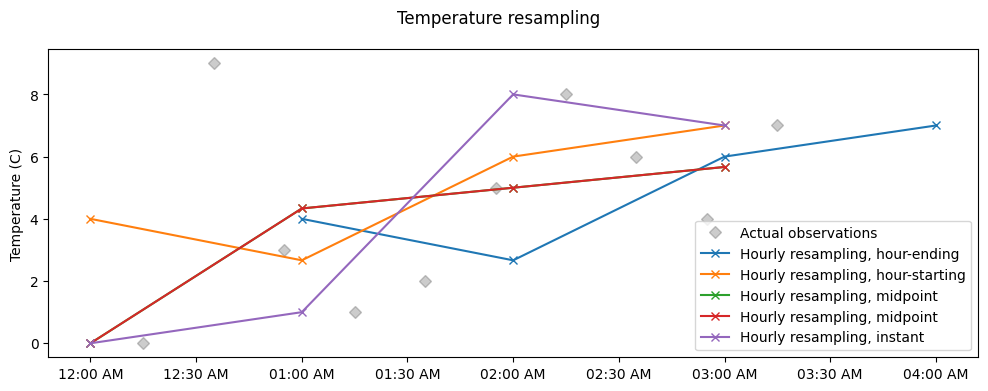

In [20]:
plot_temps(datasets, labels)

### Going beyond hourly intervals

Every example of the `rolling_*()` functions so far has specified `"h"` for the second argument. This is a [frequency string](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) from Pandas. You can pass any frequency string to get data resampled at different intervals - see the link for more information on how to use the strings.

As another example, we could resample our data to get half-hourly intervals:

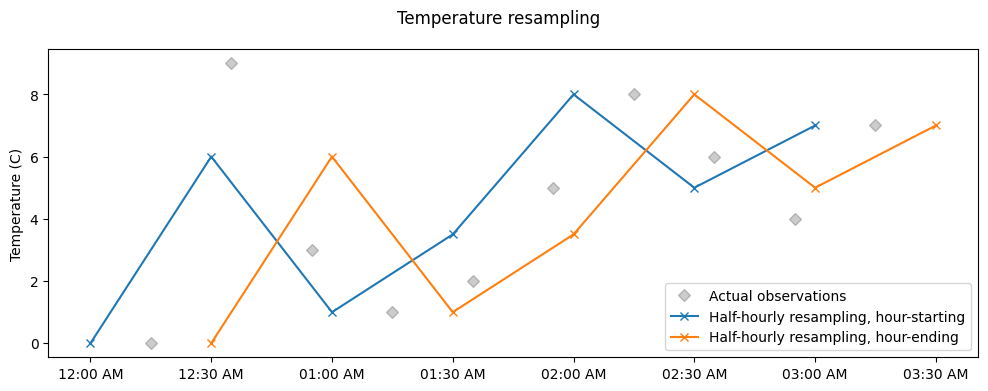

In [21]:
temps_30min_starting = riweather.rollup_starting(temps, "30min", upsample_first=False)
temps_30min_ending = riweather.rollup_ending(temps, "30min", upsample_first=False)

datasets = [
    temps,
    temps_30min_starting,
    temps_30min_ending,
]

labels = [
    "Actual observations",
    "Half-hourly resampling, hour-starting",
    "Half-hourly resampling, hour-ending",
]

plot_temps(datasets, labels)

### Upsampling before resampling

So far, we have used all of the rollup functions with the parameter `upsample_first=False`. With this option set, the resampling is done based on the raw values and the raw values only - so, for example, the hour-ending rollup value at 1 AM is precisely the average of all raw values that occurred between 12 AM and 1 AM.

This isn't always the most accurate way to arrive at a single representative value for the entire hour (or half-hour, or whatever the desired time interval is). Consider the following temperatures:

In [22]:
temps2 = pd.Series(
    [1, 2, 10],
    index=pd.date_range("2023-01-01 00:01", "2023-01-01 01:05", freq="32min"),
)
temps2

2023-01-01 00:01:00     1
2023-01-01 00:33:00     2
2023-01-01 01:05:00    10
Freq: 32min, dtype: int64

There are two observations between 12 AM and 1 AM: 1 degree at 12:01 and 2 degrees at 12:33. If we were to simply take the average in our hour-ending resampling procedure, we would end up with a value of 1.5 degrees at 1 AM.

In [23]:
riweather.rollup_ending(temps2, "h", upsample_first=False)

2023-01-01 01:00:00     1.5
2023-01-01 02:00:00    10.0
Freq: h, dtype: float64

However, we can see that the temperature rose to 10 degrees by 1:05, so it's safe to say there were some higher temperatures in the second half of the 12 AM hour that were not captured by averaging the two observations we had available, and so 1.5 degrees is likely an underestimate of the average temperature over that period.

We can address this problem by first _upsampling_ the observations before resampling them. Upsampling means taking data from one time interval to a finer-grained time interval. In this case, we perform linear interpolation to take the data up to the minute level. This allows us to better capture changes in temperature.

You can perform the upsampling step on its own with [`riweather.upsample`][]:

In [24]:
temps2_upsampled = riweather.upsample(temps2, "min")
temps2_upsampled

2023-01-01 00:01:00     1.00000
2023-01-01 00:02:00     1.03125
2023-01-01 00:03:00     1.06250
2023-01-01 00:04:00     1.09375
2023-01-01 00:05:00     1.12500
                         ...   
2023-01-01 01:01:00     9.00000
2023-01-01 01:02:00     9.25000
2023-01-01 01:03:00     9.50000
2023-01-01 01:04:00     9.75000
2023-01-01 01:05:00    10.00000
Freq: min, Length: 65, dtype: float64

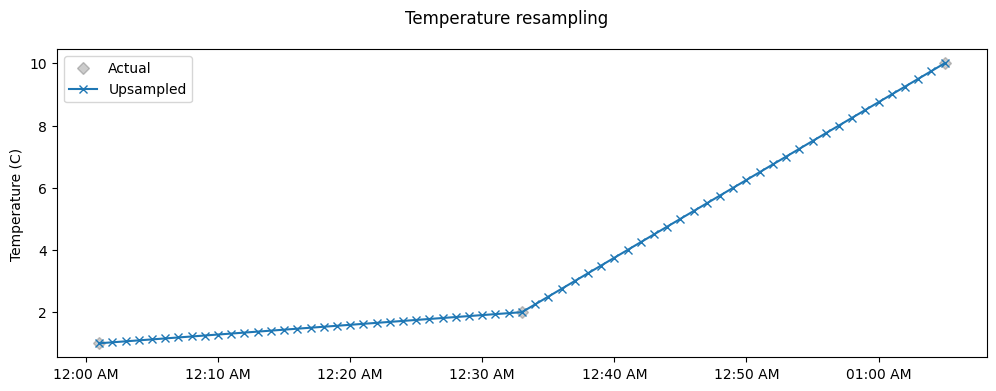

In [25]:
plot_temps([temps2, temps2_upsampled], ["Actual", "Upsampled"])

In the rollup functions, you can perform the upsampling and resampling all in one step by passing `upsample_first=True` (this is the default, so you can also just omit it).

In [27]:
riweather.rollup_ending(temps2, "h")

2023-01-01 01:00:00    3.3
2023-01-01 02:00:00    9.5
Freq: h, dtype: float64

The resampled 1 AM value is now 3.3 degrees, up from 1.5 in the other approach.

Going back to the first toy example, let's observe the difference in hour-ending values with and without the initial upsampling:

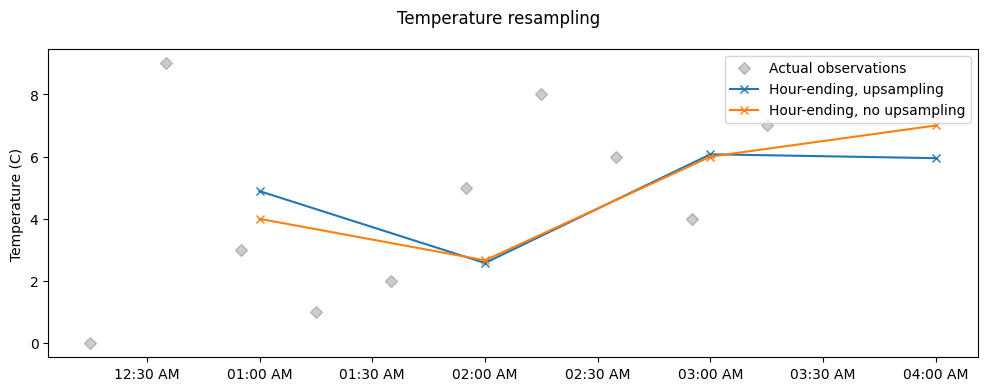

In [28]:
temps_ending_upsampled = riweather.rollup_ending(temps, "h", upsample_first=True)
temps_ending_not_upsampled = riweather.rollup_ending(temps, "h", upsample_first=False)

datasets = [
    temps,
    temps_ending_upsampled,
    temps_ending_not_upsampled,
]

labels = [
    "Actual observations",
    "Hour-ending, upsampling",
    "Hour-ending, no upsampling",
]

plot_temps(datasets, labels)

## Fetching, upsampling, and resampling from a Station

When fetching data from the ISD, you can perform all of the resampling in a single step by passing the appropriate parameters to [`riweather.Station.fetch_data`][].

In [29]:
s = riweather.Station("720534")

In [33]:
temps = s.fetch_data(
    2024, 
    "air_temperature", 
    period="h", 
    rollup="ending", 
    upsample_first=True,
)
temps.head()

,air_temperature.temperature_c,air_temperature.temperature_f
2024-01-01 01:00:00+00:00,0.653804,33.176848
2024-01-01 02:00:00+00:00,-1.263333,29.726000
2024-01-01 03:00:00+00:00,-3.657917,25.415750
2024-01-01 04:00:00+00:00,-5.146250,22.736750
2024-01-01 05:00:00+00:00,-6.179583,20.876750


### Customizing the resampling process

When used in this way, [`riweather.Station.fetch_data`][] performs three steps:

1. Fetching data from the ISD at the original time scale
2. Upsample to minute-level (if desired)
3. Resample to the given time interval

Each of these steps is exposed by the `riweather` API as separate functions, so if you want to directly manipulate the data with Pandas, you may store the intermediate datasets and use them however you want.

To recreate the exact steps performed in [`fetch_data`][riweather.Station.fetch_data]:

In [37]:
temps_raw = s.fetch_data(2024, "air_temperature", include_quality_codes=False)
temps_upsampled = riweather.upsample(temps_raw, "min")
temps_resampled = riweather.rollup_ending(temps_upsampled, upsample_first=False)

In [38]:
temps_resampled.head()

,air_temperature.temperature_c,air_temperature.temperature_f
2024-01-01 01:00:00+00:00,0.653804,33.176848
2024-01-01 02:00:00+00:00,-1.263333,29.726000
2024-01-01 03:00:00+00:00,-3.657917,25.415750
2024-01-01 04:00:00+00:00,-5.146250,22.736750
2024-01-01 05:00:00+00:00,-6.179583,20.876750
